In [7]:
import json
import os
import cv2
import numpy as np
import random

from custom_utils import ensure_directories_exist
from amodal_utils import get_bbox_from_mask, get_coco_bbox_from_mask, save_image, get_image_paths_from_folder, mask_to_polygon, resize_image_and_masks
from coco_json import initialize_coco_json, save_coco_json, add_to_coco_json
from visualization_utils import visualize_merged_amodal_and_modal, visualize_all_masks
from config import INPUT_PATHS, OUTPUT_PATHS, HYPERPARAMETERS

#### Merged image generation

In [8]:
def merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask, offset_y=0):
    # 오이 객체 중심 계산
    cucumber_bbox = get_bbox_from_mask(cucumber_mask)
    cuc_center_x = (cucumber_bbox[0] + cucumber_bbox[2]) // 2
    cuc_center_y = (cucumber_bbox[1] + cucumber_bbox[3]) // 2

    # 잎 이미지 크기와 위치 계산
    leaf_h, leaf_w = leaf_image.shape[:2]
    leaf_x = cuc_center_x - leaf_w // 2
    leaf_y = cuc_center_y + offset_y - leaf_h // 2

    # 잎 마스크 생성
    merged_image = cucumber_image.copy()
    leaf_mask = np.zeros((cucumber_image.shape[0], cucumber_image.shape[1]), dtype=np.uint8)

    for i in range(leaf_h):
        for j in range(leaf_w):
            if leaf_image[i, j, 3] > 0:  # 투명하지 않은 경우
                merged_image[leaf_y + i, leaf_x + j] = leaf_image[i, j, :3]
                leaf_mask[leaf_y + i, leaf_x + j] = 255  # 잎 마스크 업데이트

    return merged_image, leaf_mask

def synthesize_two_images(cucumber_image_path, cucumber_mask_path, leaf_image_path, offset_y=0, save_dir=None, global_image_id=0, target_size=(768, 1024)):
    
    # 오이 이미지와 잎 이미지 로드
    cucumber_image = cv2.imread(cucumber_image_path, cv2.IMREAD_UNCHANGED)
    leaf_image = cv2.imread(leaf_image_path, cv2.IMREAD_UNCHANGED)
    cucumber_mask = cv2.imread(cucumber_mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 이미지를 합성
    merged_image, leaf_mask = merge_leaf_to_cucumber(cucumber_image, leaf_image, cucumber_mask, offset_y)

    # 리사이즈
    resized_image, resized_masks, scale_x, scale_y = resize_image_and_masks(
        merged_image, [cucumber_mask, leaf_mask], target_size=target_size
    )
    amodal_mask, leaf_mask = resized_masks

    # 합성 이미지 저장
    cucumber_image_name = os.path.basename(cucumber_image_path)
    merged_image_name = f"{os.path.splitext(cucumber_image_name)[0]}_merged_{global_image_id:06d}.png"
    resized_image_path = save_image(save_dir, merged_image_name, resized_image)

    return resized_image_path, amodal_mask, leaf_mask

##### amodal mask info (occluder, occuluded)

In [9]:
# modal 마스크 생성
def generate_modal_mask(cucumber_mask, leaf_mask, image_name, save_dir):
    # 겹치는 부분 (오이 마스크와 잎 마스크가 동시에 255인 부분을 추출)
    overlap_mask = (cucumber_mask == 255) & (leaf_mask == 255)
    
    # Modal 마스크 생성 (겹치는 부분을 제외한 오이 마스크)
    modal_mask = cucumber_mask.copy()
    modal_mask[overlap_mask] = 0  # overlap 영역을 0으로 만들어 겹친 부분 제거

    #visualize_all_masks(cucumber_mask, leaf_mask, modal_mask)
    # 마스크를 PNG 형식으로 저장 (이진화된 값 0 또는 255로 저장)
    modal_filename = f"{os.path.splitext(image_name)[0]}_amodal_mask.png"
    amodal_mask_path = save_image(save_dir, modal_filename, cucumber_mask)

    # 마스크를 PNG 형식으로 저장 (이진화된 값 0 또는 255로 저장)
    modal_filename = f"{os.path.splitext(image_name)[0]}_modal_mask.png"
    modal_mask_path = save_image(save_dir, modal_filename, modal_mask)

    # Overlap 마스크 저장
    overlap_filename = f"{os.path.splitext(image_name)[0]}_overlap_mask.png"
    overlap_mask_path = save_image(save_dir, overlap_filename, overlap_mask.astype(np.uint8) * 255)

    return modal_mask, overlap_mask, modal_mask_path, overlap_mask_path

In [ ]:
def generate_annotation(amodal_mask, modal_mask, global_id, image_id, category_id, occluder_segm=[]):
    amodal_segm = mask_to_polygon(amodal_mask)
    amodal_bbox = get_coco_bbox_from_mask(amodal_mask)
    
    process_mask = modal_mask if modal_mask is not None else amodal_mask  # 보이는 영역이 없으면 전체 영역(amodal_mask) 사용
    area = float(np.sum(process_mask == 255))
    segmentation = visible_segm = mask_to_polygon(process_mask)
    visible_bbox = get_coco_bbox_from_mask(process_mask)

    annotation = {
        "id": global_id,
        "image_id": image_id,
        "category_id": category_id,
        "iscrowd": 0,
        "amodal_bbox": amodal_bbox,
        "visible_bbox" : visible_bbox,
        "bbox": amodal_bbox,  # COCO 포맷 BBox 계산
        "area": area,
        "amodal_area": float(np.sum(amodal_mask == 255)),
        "amodal_segm": amodal_segm,
        "segmentation": amodal_segm,  # Segmentation polygon 생성
        "visible_segm": visible_segm,
        "background_objs_segm": [],  # 기본값
        "occluder_segm": occluder_segm,
    }
    return annotation

def process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, coco_json, global_image_id, global_annotation_id, offset_y=0):

    # 1. 오이 마스크 불러오기
    
    
    print("오이 이미지 합성 시작...")
    # 2. 오이 이미지에 잎 이미지를 합성하고 저장
    merged_image_path, amodal_mask, leaf_mask  = synthesize_two_images(cucumber_image_path, cucumber_mask_path, leaf_cropped_image_path, offset_y, save_dir, global_image_id)

    print("Modal 마스크 생성 시작...")
    # 3. Modal 마스크 생성 및 겹치는 부분 (가림) 정보 계산
    modal_mask, overlap_mask, modal_mask_path, overlap_mask_path = generate_modal_mask(
        amodal_mask, leaf_mask, os.path.basename(merged_image_path), mask_save_dir)
    
    print("COCO Format 데이터 생성 시작...")
    # 5. 공통 Annotation 생성
    cucumber_annotation = generate_annotation(
        amodal_mask=amodal_mask,
        modal_mask = modal_mask,
        global_id=global_annotation_id,
        image_id=global_image_id,
        category_id=1,
        occluder_segm=mask_to_polygon(leaf_mask)
    )
    coco_json["annotations"].append(cucumber_annotation)
    global_annotation_id += 1

    # 6. 잎 Annotation 생성
    leaf_annotation = generate_annotation(
        amodal_mask=leaf_mask,
        modal_mask = None,
        global_id=global_annotation_id,
        image_id=global_image_id,
        category_id=2,  # 잎 클래스 ID
    )
    coco_json["annotations"].append(leaf_annotation)
    global_annotation_id += 1
    
    # 7. 이미지 정보 추가
    image_info = {
        "id": global_image_id,
        "width": int(amodal_mask.shape[1]),
        "height": int(amodal_mask.shape[0]),
        "file_name": os.path.basename(merged_image_path),
    }
    coco_json["images"].append(image_info)

    # ID 증가
    global_image_id += 1

    # 9. 시각화
    visualize_merged_amodal_and_modal(cv2.imread(merged_image_path, cv2.IMREAD_UNCHANGED), amodal_mask, modal_mask)

    return coco_json, global_image_id, global_annotation_id

### hypter parameters

In [11]:
''' input'''
cucumber_images_dir = INPUT_PATHS["cucumber_images_dir"]
cucumber_masks_dir = INPUT_PATHS["cucumber_masks_dir"]
leaf_cropped_dir = INPUT_PATHS["leaf_cropped_dir"]

''' output dir'''
save_dir = OUTPUT_PATHS["save_dir"]
mask_save_dir = OUTPUT_PATHS["mask_save_dir"]
json_dir = OUTPUT_PATHS["json_dir"]
ensure_directories_exist([save_dir, mask_save_dir, json_dir])

offset_y_range = HYPERPARAMETERS["offset_y_range"]
image_index_start = HYPERPARAMETERS["image_index_start"]

sample_limit = HYPERPARAMETERS["saple_limit"]  # 생성할 샘플 수
sample_count = 0   # 현재 생성된 샘플 수

디렉터리 생성됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5
디렉터리 생성됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5
디렉터리 생성됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_info5


#### Multiple Generation Code

오이 마스크가 없습니다: oi_347_1
oi_398_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000000.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000000_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000000_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000000_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 0 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_0.png


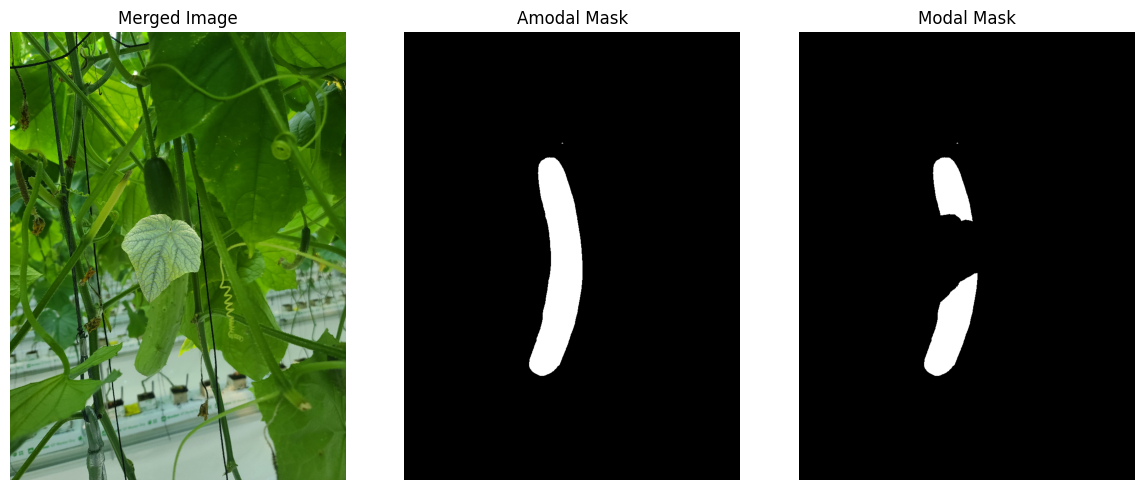

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000001.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000001_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000001_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000001_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 2 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_2.png


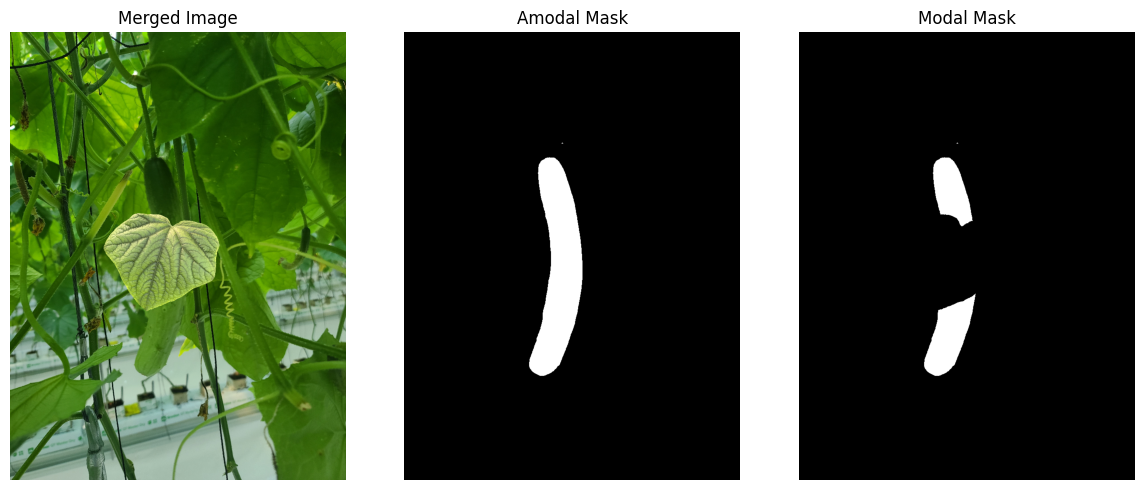

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000002.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000002_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000002_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000002_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 4 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_4.png


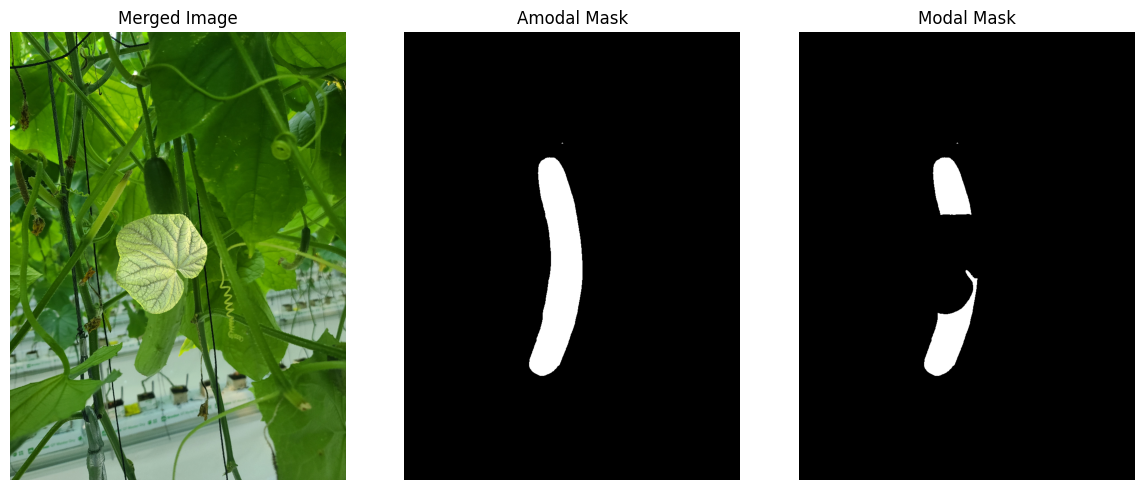

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000003.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000003_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000003_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000003_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 6 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_6.png


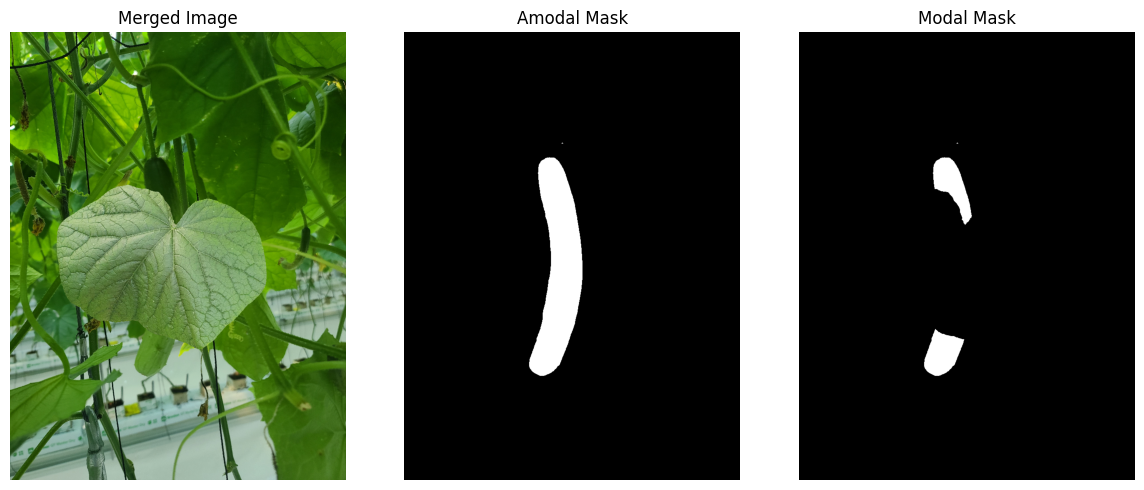

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000004.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000004_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000004_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000004_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 8 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_8.png


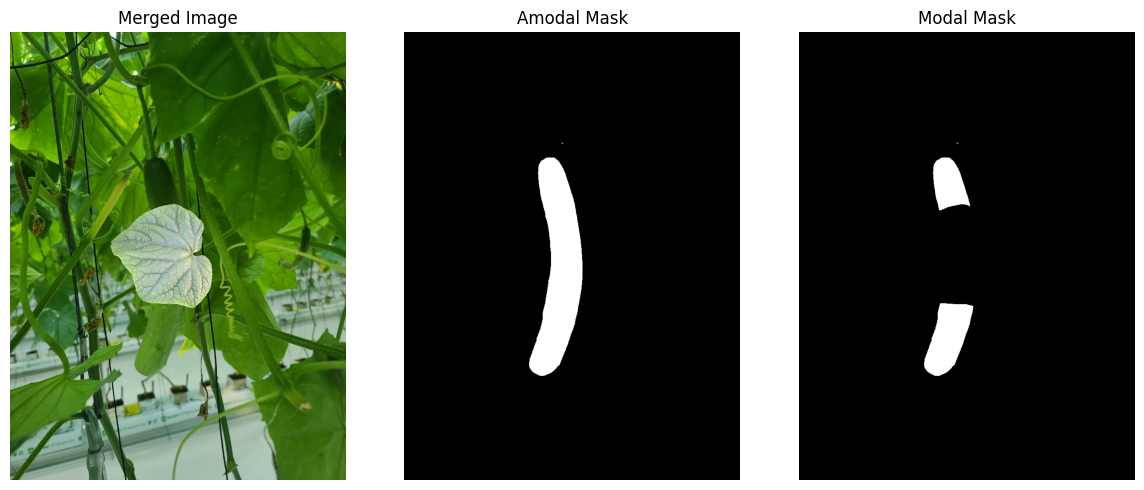

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000005.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000005_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000005_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000005_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 10 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_10.png


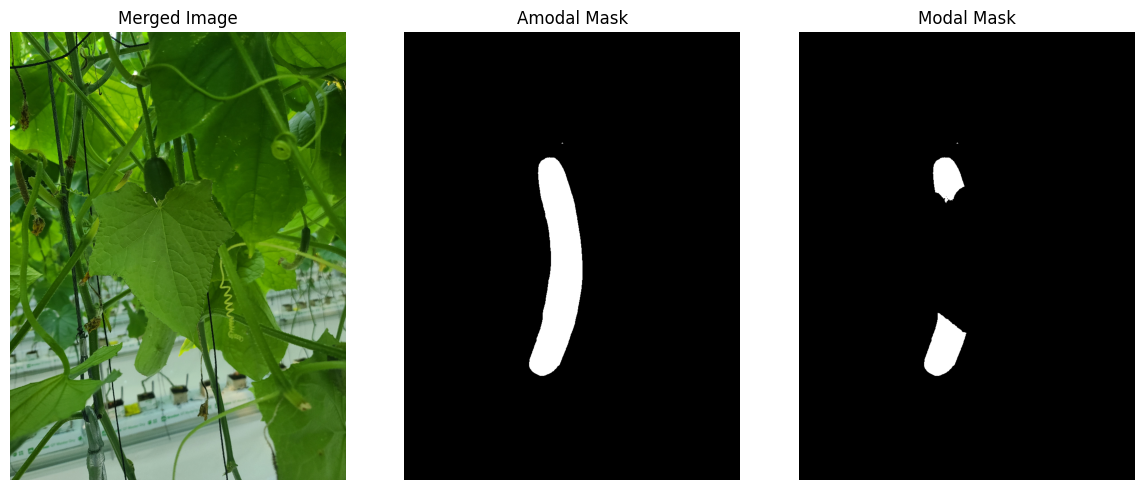

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000006.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000006_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000006_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000006_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 12 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_12.png


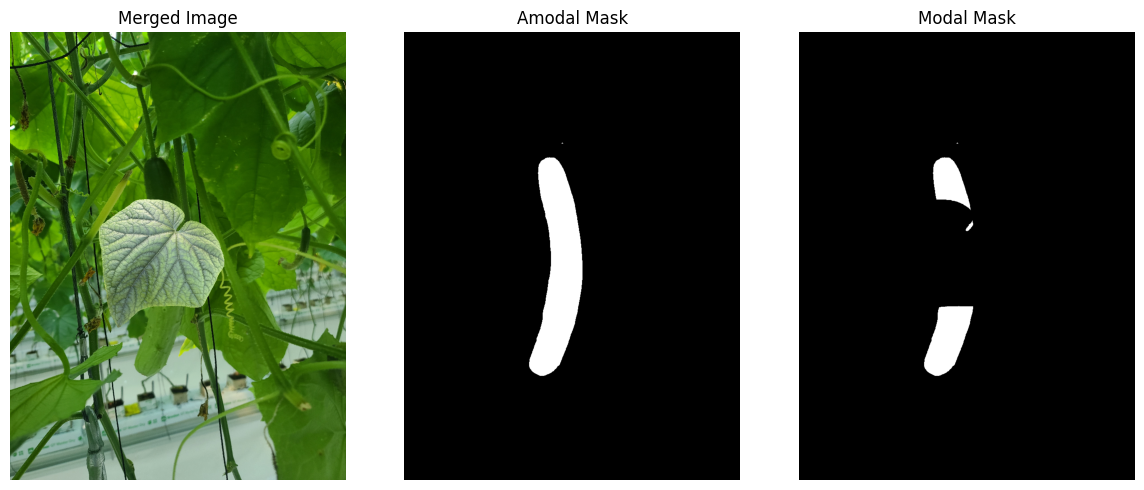

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000007.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000007_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000007_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000007_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 14 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_14.png


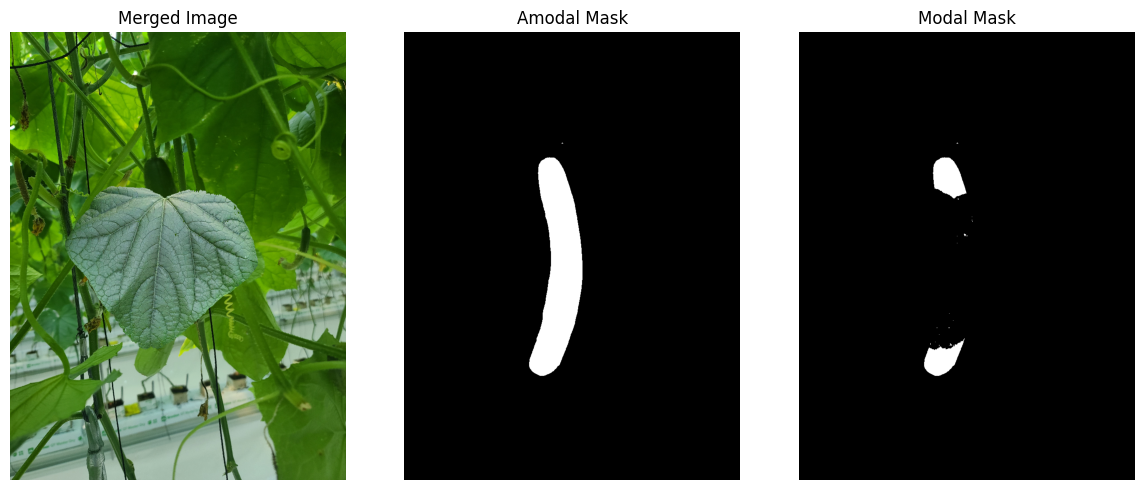

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000008.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000008_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000008_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000008_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 16 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_16.png


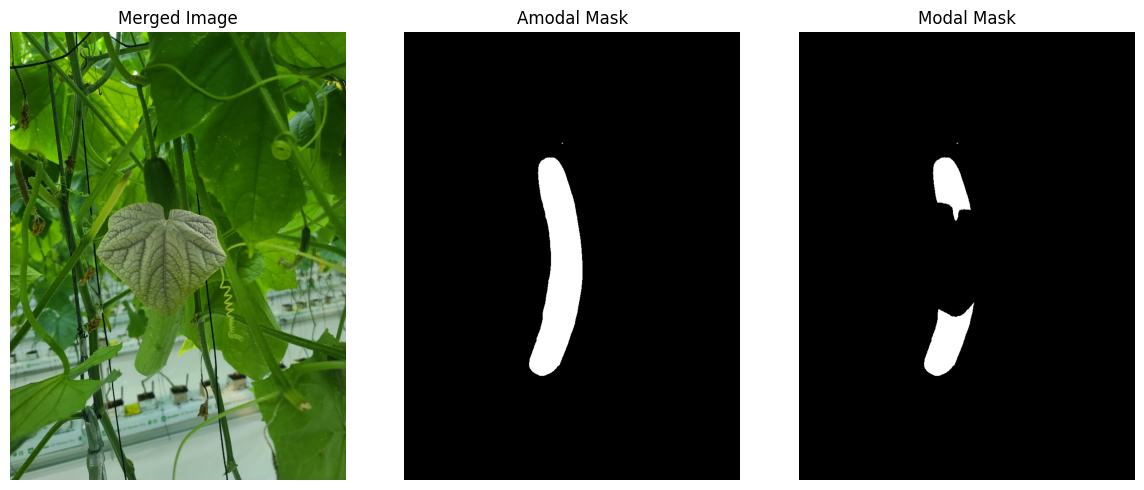

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000009.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000009_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000009_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000009_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 18 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_18.png


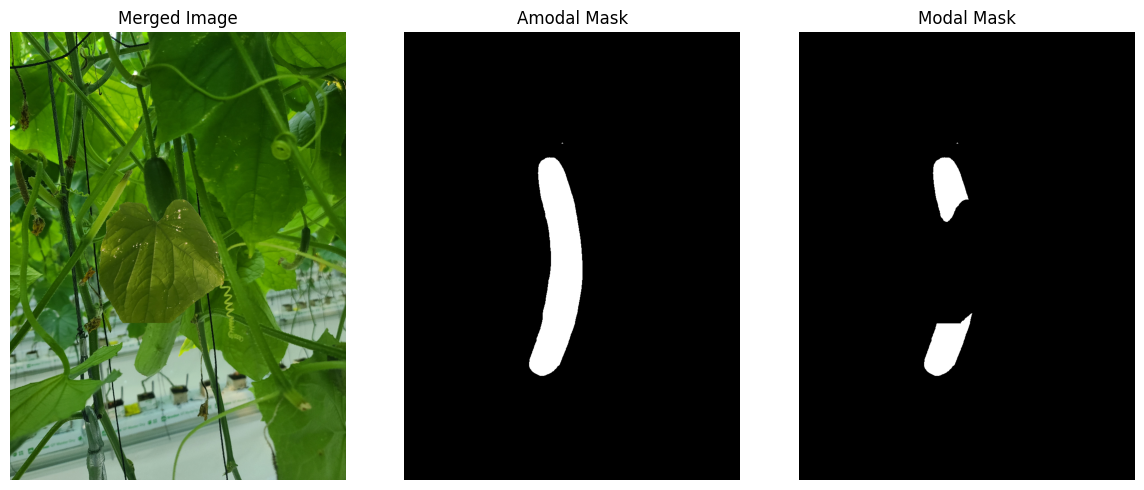

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000010.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000010_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000010_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000010_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 20 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_20.png


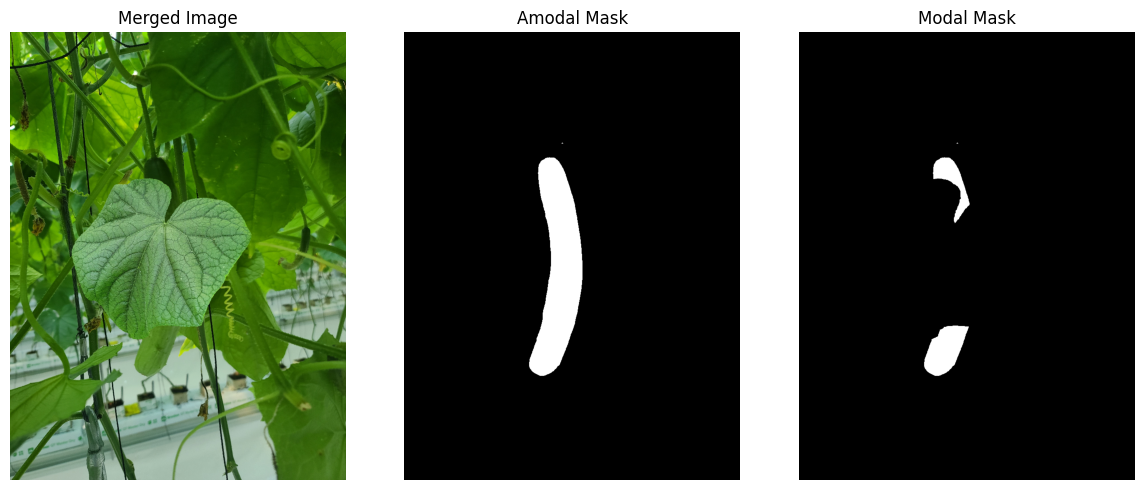

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000011.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000011_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000011_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000011_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 22 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_22.png


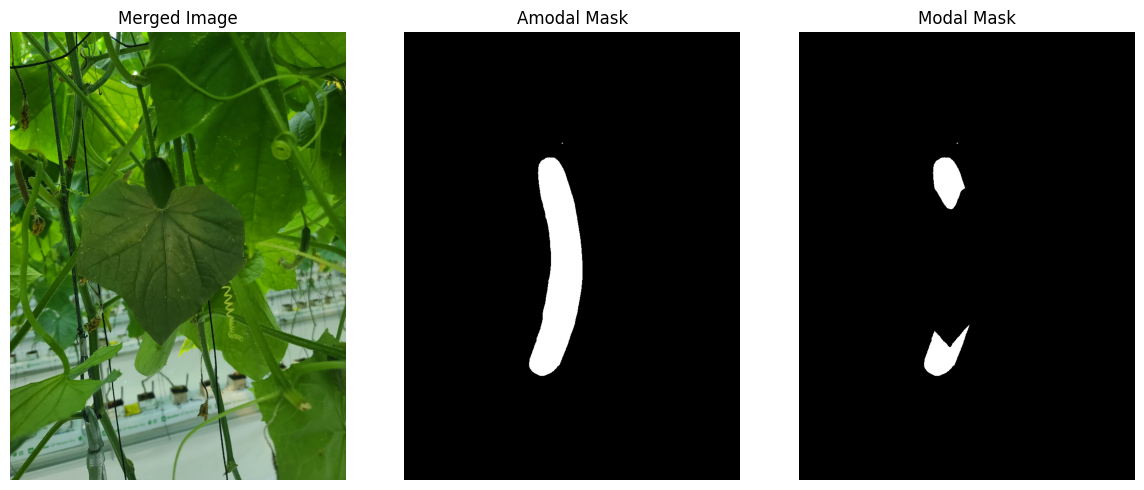

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000012.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000012_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000012_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000012_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 24 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_24.png


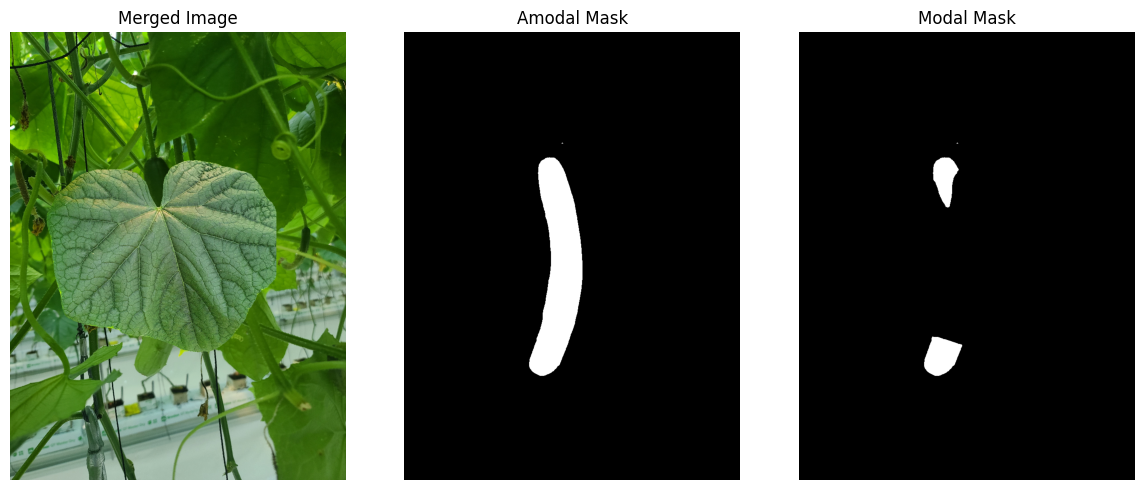

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000013.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000013_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000013_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000013_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 26 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_26.png


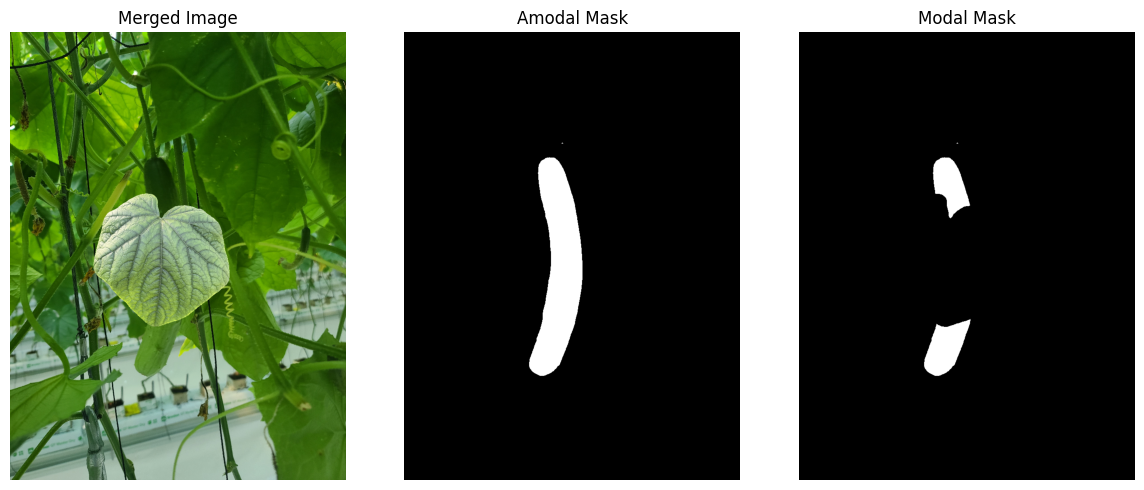

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000014.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000014_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000014_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000014_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 28 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_28.png


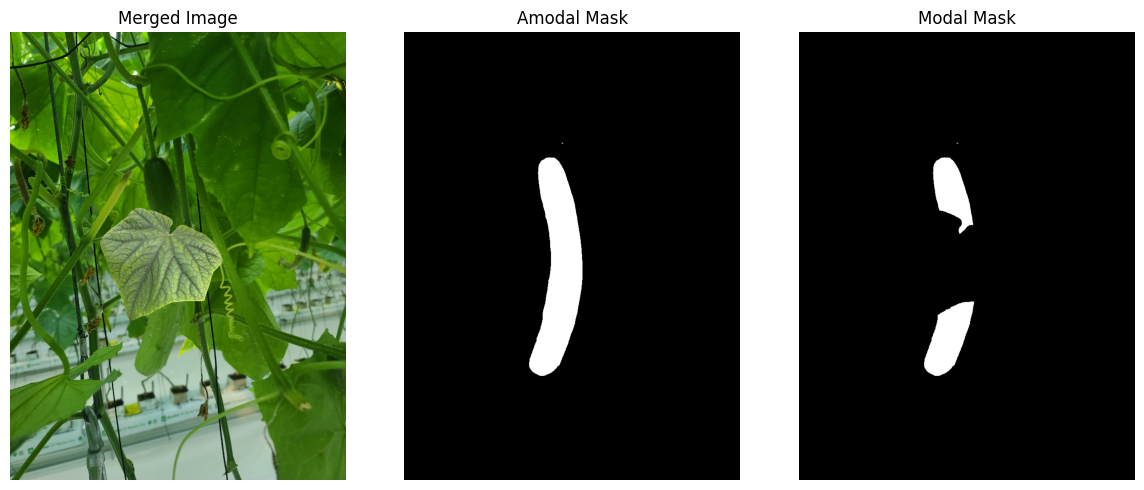

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000015.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000015_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000015_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000015_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 30 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_30.png


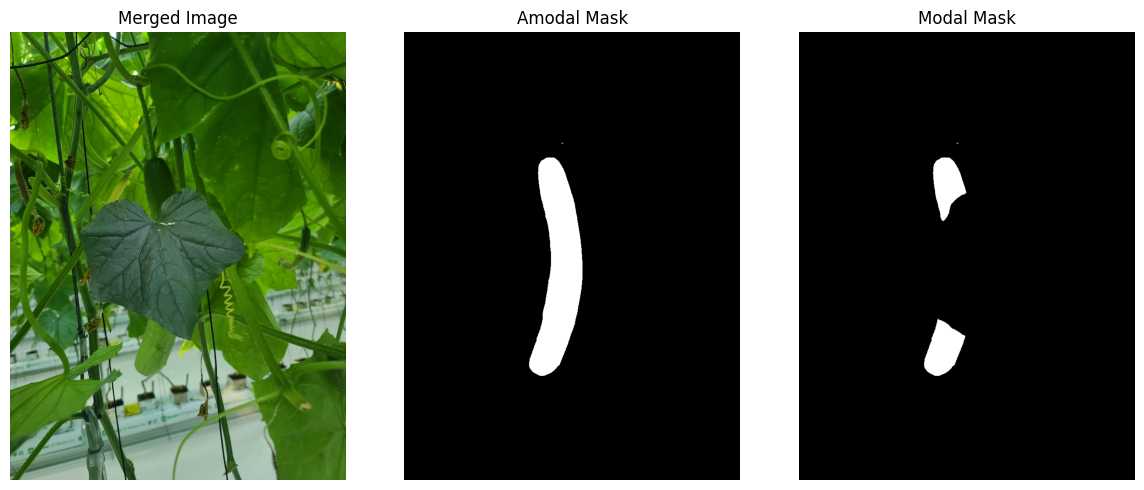

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000016.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000016_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000016_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000016_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 32 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_32.png


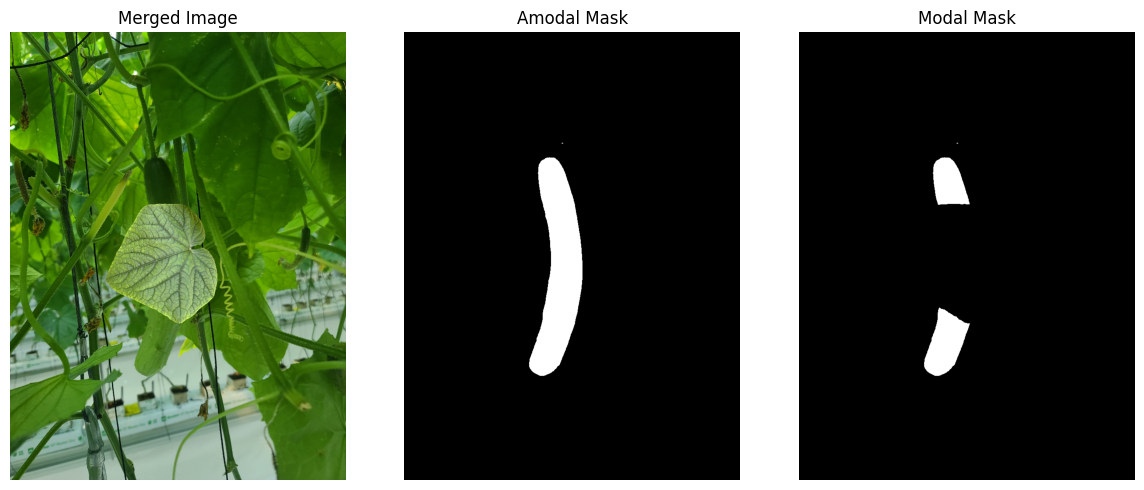

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000017.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000017_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000017_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000017_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 34 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_34.png


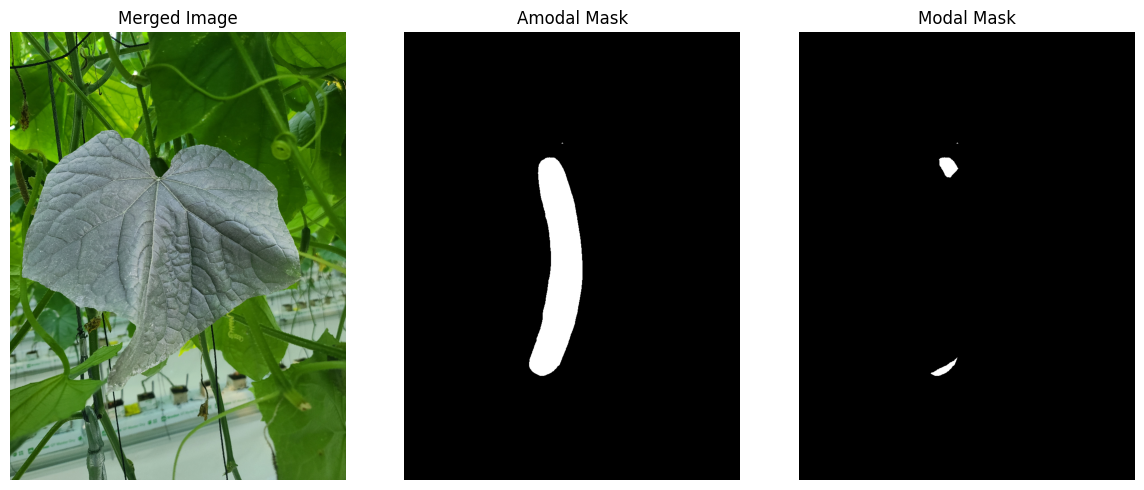

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000018.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000018_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000018_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000018_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 36 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_36.png


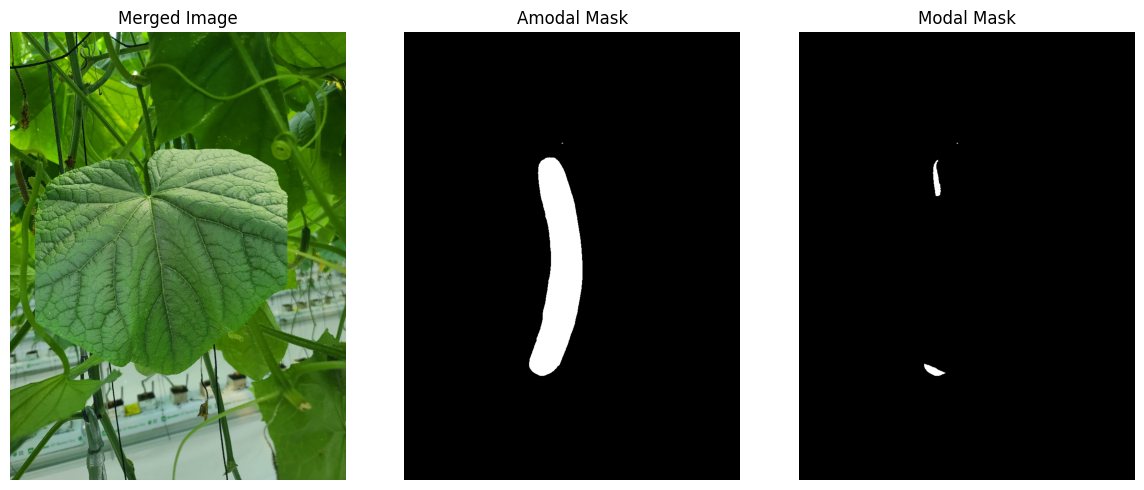

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/amodal_images5/oi_398_1_merged_000019.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000019_amodal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000019_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/modal_masks5/oi_398_1_merged_000019_overlap_mask.png
COCO Format 데이터 생성 시작...
Saved amodal mask for ID 38 at /home/knuvi/Desktop/song/occlusion-mask-generation/data/synthesis/test/test_38.png


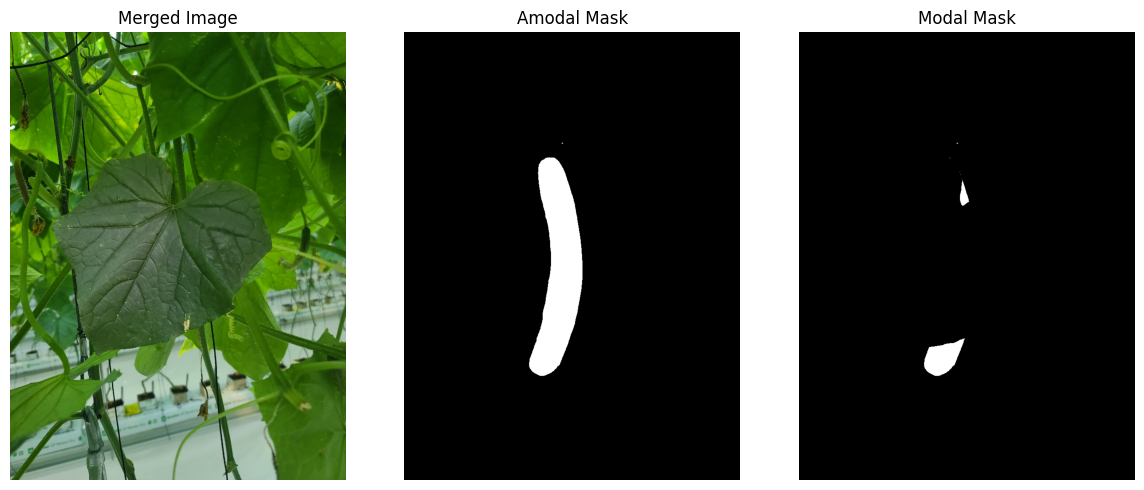

20개의 샘플 생성 완료.
oi_685_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_235_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_231_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
오이 마스크가 없습니다: oi_236_2
오이 마스크가 없습니다: oi_077_1
oi_604_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
오이 마스크가 없습니다: oi_419_1
oi_373_2에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_314_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
오이 마스크가 없습니다: oi_063_1
oi_179_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
오이 마스크가 없습니다: oi_161_1
oi_689_4에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_358_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_222_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_615_2에 대한 2개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_083_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_073_1에 대한 1개의 마스크 확보...
264 개의 잎 이미지와 합성 시작...
20개의 샘플 생성 완료.
oi_536_1에 대한 1개의 마스크 확보..

In [12]:
# 특정 클래스 마스크만 선택 (클래스 0: 오이)
def get_cucumber_masks(mask_dir, image_name):
    cucumber_masks = []
    for mask_file in os.listdir(mask_dir):
        # 파일명이 이미지명과 매칭되고 클래스가 0인 마스크만 선택
        if mask_file.startswith(image_name) and '_0_' in mask_file:
            cucumber_masks.append(os.path.join(mask_dir, mask_file))
    return cucumber_masks

# cucumber 이미지 파일 불러오기
cucumber_image_paths = get_image_paths_from_folder(cucumber_images_dir)

# COCO JSON 초기화
coco_json = initialize_coco_json()

global_image_id, global_annotation_id = 0,0
# 각 cucumber 이미지에 대해 마스크와 잎 합성
for cucumber_image_path in cucumber_image_paths:
    # 이미지 이름에서 확장자를 제거하여 기본 이미지명을 가져옴
    image_name = os.path.splitext(os.path.basename(cucumber_image_path))[0]
    
    # 해당 이미지의 오이 마스크들 가져오기 (클래스가 0인 것만)
    cucumber_mask_paths = get_cucumber_masks(cucumber_masks_dir, image_name)

    if len(cucumber_mask_paths) == 0:
        print(f"오이 마스크가 없습니다: {image_name}")
        continue

    # 잎 이미지 경로 선택 (임의의 하나 또는 여러 잎을 사용할 수 있음)
    leaf_cropped_image_paths = get_image_paths_from_folder(leaf_cropped_dir)
    print(f'{image_name}에 대한 {len(cucumber_mask_paths)}개의 마스크 확보...')
    
    # 오이 마스크와 잎 이미지 합성 처리
    for cucumber_mask_path in cucumber_mask_paths:
        print(f'{len(leaf_cropped_image_paths)} 개의 잎 이미지와 합성 시작...')

        for leaf_cropped_image_path in leaf_cropped_image_paths:

            if sample_count >= sample_limit:
                print(f"{sample_limit}개의 샘플 생성 완료.")
                break  # 안쪽 루프 종료

            # offset_y 값을 범위 내에서 무작위로 설정
            offset_y = random.randint(offset_y_range[0], offset_y_range[1])

            # 오이와 잎 이미지를 합성하는 함수 호출
            coco_json,  global_image_id, global_annotation_id = process_amodal_images_and_masks(
                cucumber_image_path=cucumber_image_path,
                leaf_cropped_image_path=leaf_cropped_image_path,
                cucumber_mask_path=cucumber_mask_path,
                save_dir=save_dir,
                mask_save_dir=mask_save_dir,
                coco_json=coco_json,
                global_image_id= global_image_id,
                global_annotation_id= global_annotation_id,
                offset_y=offset_y,
            )
            sample_count += 1  # 샘플 생성 수 증가

        if sample_count >= sample_limit:
            break  # 바깥쪽 루프 종료

# 최종 COCO JSON 저장
output_json_path = os.path.join(json_dir, "dataset.json")
save_coco_json(coco_json, output_json_path)

In [ ]:
# 실행 예시
''' input'''
cucumber_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/images/oi_002_1.jpg"
leaf_cropped_image_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_029_3_1_00.png"
cucumber_mask_path = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/masks/oi_002_1_0_00.png"


''' output dir'''
save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images"
mask_save_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks"
json_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_info"
offset_y = 30
image_index = 0
#
process_amodal_images_and_masks(cucumber_image_path, leaf_cropped_image_path, cucumber_mask_path, save_dir, mask_save_dir, json_dir, image_index, offset_y)

오이 이미지 합성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/amodal_images/oi_002_1_merged_000000.png
Modal 마스크 생성 시작...
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks/oi_002_1_merged_000000_modal_mask.png
Mask 저장됨: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/modal_masks/oi_002_1_merged_000000_overlap_mask.png
COCO Format 데이터 생성 시작...


TypeError: string indices must be integers

In [13]:
import os
import shutil

# 특정 클래스(잎 클래스 1) 이미지를 선택하여 다른 폴더로 복사
def copy_leaves_images(cropped_objects_dir, target_dir, class_id="1"):
    # 타겟 디렉토리가 없으면 생성
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # cropped_objects 폴더 내 파일들 탐색
    for file_name in os.listdir(cropped_objects_dir):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            # 파일명에서 클래스 정보를 추출 (예: cropped_oi_001_1_xx.png)
            parts = file_name.split('_')
            if len(parts) > 4 and parts[4] == class_id:  # 클래스가 4번째 위치에 있는지 확인
                source_file = os.path.join(cropped_objects_dir, file_name)
                target_file = os.path.join(target_dir, file_name)
                
                # 파일 복사
                shutil.copy2(source_file, target_file)
                print(f"복사 완료: {source_file} -> {target_file}")

# 경로 설정
cropped_objects_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects"
selected_cropped_leaves_dir = "/home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves"

# 잎 클래스(1) 이미지만 선택하여 복사
copy_leaves_images(cropped_objects_dir, selected_cropped_leaves_dir, class_id="1")


복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_054_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_054_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_139_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_139_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_221_3_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_221_3_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_100_2_1_00.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_leaves/cropped_oi_100_2_1_00.png
복사 완료: /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/cropped_objects/cropped_oi_008_3_1_01.png -> /home/knuvi/Desktop/song/cucumber-image/data/oi_seg/selected_cropped_lea